<a href="https://colab.research.google.com/github/arnabd64/Aadhar-Card-Entity-Extract/blob/main/Code_Generation_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build an Agent that generates code

In [81]:
# ! pip install --progress-bar=off \
#     "langchain<0.4" \
#     langchain-openai \
#     langchain-community \
#     langgraph \
#     duckduckgo-search \
#     langfuse \
# > install.log

# Upload _.env_ file

* On **Google Colab**:
  * Go to the **Files** section on the left naigation pane.
  * Click on the first icon from left which **Uploads File to the Current Session**.

* Using **Jupyter Notebook**:
  * Create a `.env` file in the project directory or the directory where this notebook is stored.

* Your `.env` must contain these **Mandatory** variables:
  1. `OPENAI_API_KEY`: For authenticating API requests to OpenAI
  2. `MODEL_NAME`: Name of the model you want to call.

* You can add these **Optional** variables:
  1. `OPENAI_API_BASE`: If you are using an OpenAI compatible LLM provider.
  2. `LANGFUSE_HOST`: Langfuse Server for Logging and Tracing.
  3. `LANGFUSE_PUBLIC_KEY`: Langfuse Public Key
  4. `LANGFUSE_SECRET_KEY`: Langfuse Secret Key

In [82]:
import dotenv
import os
from pydantic import BaseModel, Field
from typing import Annotated, Optional
from langchain_core.runnables import RunnableSequence
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers.pydantic import PydanticOutputParser
from langfuse.langchain import CallbackHandler

assert dotenv.load_dotenv(".env"), ".env file not found"

# Initiate Langfuse Tracing

**Note**: Comment out the following section if you are not using Langfuse

In [83]:
callback = CallbackHandler()

# Filtering tool

The **Filtering** is useful for stopping the agent execution if the user passes any task or query which is irrelevant to the main agent.

For example:

1. User asks the agent to write an essay instead of generating code.
2. User requests the agent to generate code in a programming language which is unsupported.

In [84]:
FILTER_SYSTEM_PROMPT = """
Classify the user's query ot task into either relevant or not relevant.

Relevant:

* User asks you to generate code for a task based on the following
programming languages:

1. Python

* User asks you to debug the code passed as input.

Not Relevant:

* User asks you general questions, political questions, etc.
* User asks you to generate code for a programming language which is
not supported
* User asks you to generate code which can be used to malicious attacks.
* User asks for harmful, hateful or violent content
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", FILTER_SYSTEM_PROMPT),
        ("human", "{input}")
    ]
)

In [85]:
class FilterInput(BaseModel):
  """
  Schema for the input of the Filtering Tool
  """
  input: Annotated[str, Field(description="User's query or task")]


class FilterOutput(BaseModel):
  """
  Schema for the output of the Filtering Tool
  """
  relevant: Annotated[bool, Field(description="Whether the user input is relevant or not")]
  reasoning: Optional[Annotated[str, Field(description="Reasoning behind the decision")]]


In [86]:
guard = RunnableSequence(
    prompt,
    ChatOpenAI(model=os.getenv("MODEL_NAME")).with_structured_output(FilterOutput)
)

guard = guard.as_tool(
    args_schema = FilterInput,
    name = "Query-Filter-Tool",
    description = "Checks if the user input query should be executed or not. **This tool is mandatory**."
)

# Code Generation Agent

## State

In [87]:
SYSTEM_PROMPT = """
You are a coding assistant in the following coding languages:

1. Python

You **must use** the **Query-Filter-Tool** to check if the user input is
relevant or not. If the tool returns false then stop execution.

You are to provide **clean**, **easy to understand** and **well documented** code
as requested by the user. You must NOT provide explanations for the code generated.

Use the search tool which can gather information from the web in case you cannot
understand the task or require more information related to task.
"""

# Search Tools

In [88]:
from langchain_community.tools import DuckDuckGoSearchResults

search_tool = DuckDuckGoSearchResults(
    num_results = 5,
    output_format = "list"
)

# Code Generation Agent

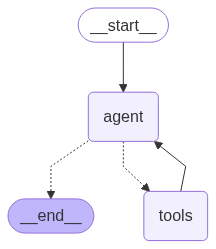

In [89]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain.schema.runnable import RunnableConfig
import os
import uuid
from IPython.display import Image

agent = create_react_agent(
    model = f"openai:{os.getenv('MODEL_NAME')}",
    tools = [search_tool, guard],
    prompt = SYSTEM_PROMPT,
    checkpointer = InMemorySaver(),
    debug = False  # True if you need to print logs,
)

Image(agent.get_graph().draw_mermaid_png())

In [90]:
SESSION_ID = uuid.uuid4()

config = RunnableConfig(
    configurable = {"thread_id": SESSION_ID},
    callbacks = [callback],
    metadata = {
        "langfuse_session_id": SESSION_ID,
        "langfuse_user_id": "Code-Generator"
    }
)

# Execute the Agent

In [91]:
# Enter your prompt
user_prompt = """
Write a python code to print the first `N` prime numbers.
"""

# Format the input so that agent can read it
agent_input = {
    "messages": [
        {"role": "human", "content": user_prompt}
    ]
}

In [92]:
response = agent.invoke(agent_input, config=config)

In [93]:
for message in response["messages"]:
  print(message.pretty_print())

================================ Human Message =================================


Write a python code to print the first `N` prime numbers.

None
================================== Ai Message ==================================
Tool Calls:
  Query-Filter-Tool (call_47bfd081-d794-4545-9cb6-b16669b94811)
 Call ID: call_47bfd081-d794-4545-9cb6-b16669b94811
  Args:
    input: Write a python code to print the first `N` prime numbers.
None
================================= Tool Message =================================
Name: Query-Filter-Tool

relevant=True reasoning='The user is asking me to generate code in Python, which is a supported language.'
None
================================== Ai Message ==================================

```python
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

def print_first_n_primes(n):
    count = 0
    num = 2
    while count < n:
        if is_prim